In [634]:
import numpy as np
import matplotlib.pyplot as plt

In [635]:
plt.rcParams['figure.figsize'] = [15,8] # size of plots in inches

<h3>Модель ДПТ в пространстве состояний</h3>

Входные воздействия: <br> 
*U* - управляющее напряжение <br>
*Mc* – момент сопротивления на валу <br>
Выходные величины: <br>
*i* – ток якоря <br>
*ω* – скорость вращения <br>
Параметры: <br>
*R* - активное сопротивление цепи якоря <br>
*Te* - постоянная якорной цепи <br>
*cF* - произведение конструктивной постоянной на номинальный магнитный поток <br>
*J* - приведенный к валу двигателя момент инерции <br>
*T* - шаг дискретизации

Определение параметров

Параметры для модели со средним значением

In [636]:
R = 0.12
Te = 0.01
cF = 2.35
J = 95
T = 0.01

Для двигателя МП7000-115У4

In [637]:
R = 0.003682;
L = 0.000156;
F = 0.4258; 
J = 172000;
C = 176;
Te = L/R;
cF = C*F;

In [638]:
T = 0.01
sec = 4
points = len(np.arange(0, sec, T))

Определение модели в простанстве состояний 

In [639]:
A = np.array([[-1/Te, -cF/(R*Te)],
              [cF/J, 0]])
B = np.array([[1/(R*Te), 0],
              [0, -1/J]])
C = np.array([[1, 0],
              [0, 1]])
D = np.array([[0, 0],
              [0, 0]])

Определение начального состояния x0

In [640]:
x0 = np.array([[0],
               [0]])

Определение входного сигнала u = (U, Mc)

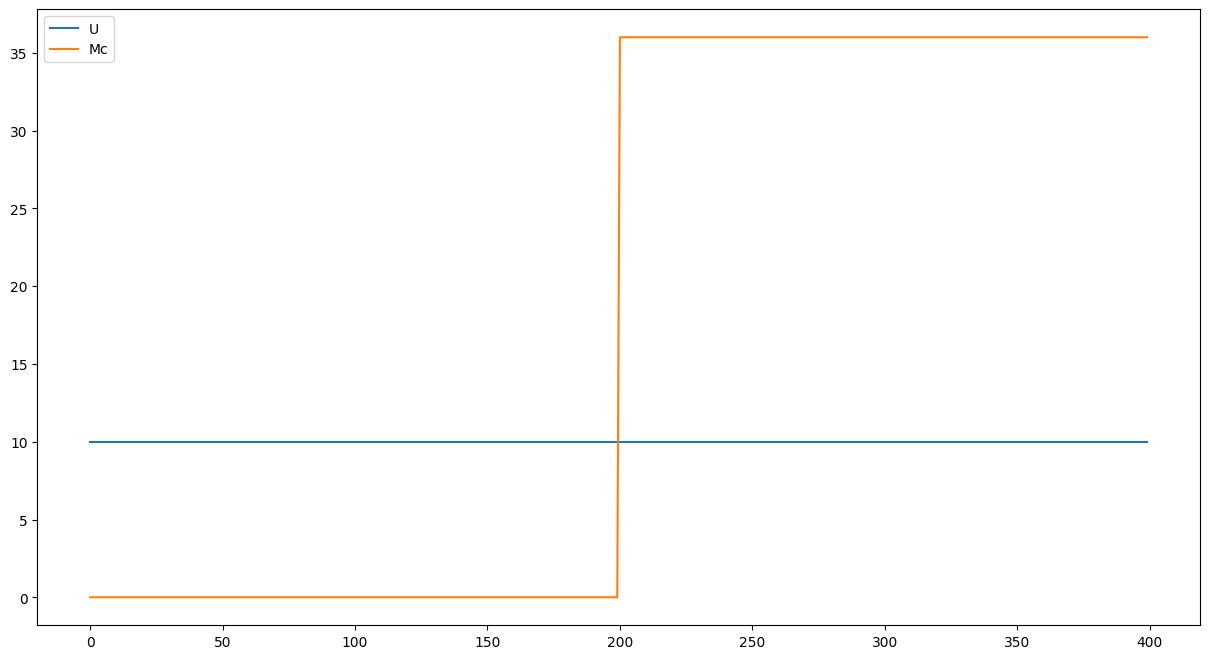

In [641]:
U = np.full((points, 1), 10)
Mc = np.repeat([0, 36], [points-(points-(2/T)), points-(2/T)]).reshape((points, 1))
plt.plot(U, label="U")
plt.plot(Mc, label="Mc")
plt.legend()
plt.show()

In [642]:
u = np.hstack((U, Mc)).reshape(points, 2, 1)

Определение выходного сигнала y

In [643]:
y = np.array([[0],
              [0]])

Вычисление матрицы перехода состояния

In [644]:
Ad = np.eye(A.shape[0]) + A * T

Вычисление входнуой матрицы для системы с дискретным временем

In [645]:
Bd = B * T

Моделирование

In [646]:
# Сохранение значений
history_y = []

# Итерация по временным шагам
for i, t in enumerate(np.arange(0, sec, T)):
    
    # Вычисление следующего состояния
    x = np.dot(Ad, x0) + np.dot(Bd, u[i])

    # Вычисление выхода
    y = np.dot(C, x) + np.dot(D, u[i])
    history_y.append(y)
    
    # Обновление исходного состояния
    x0 = x

In [647]:
np.arange(0, sec, T).shape

(400,)

In [648]:
history_y_array = np.array(history_y)

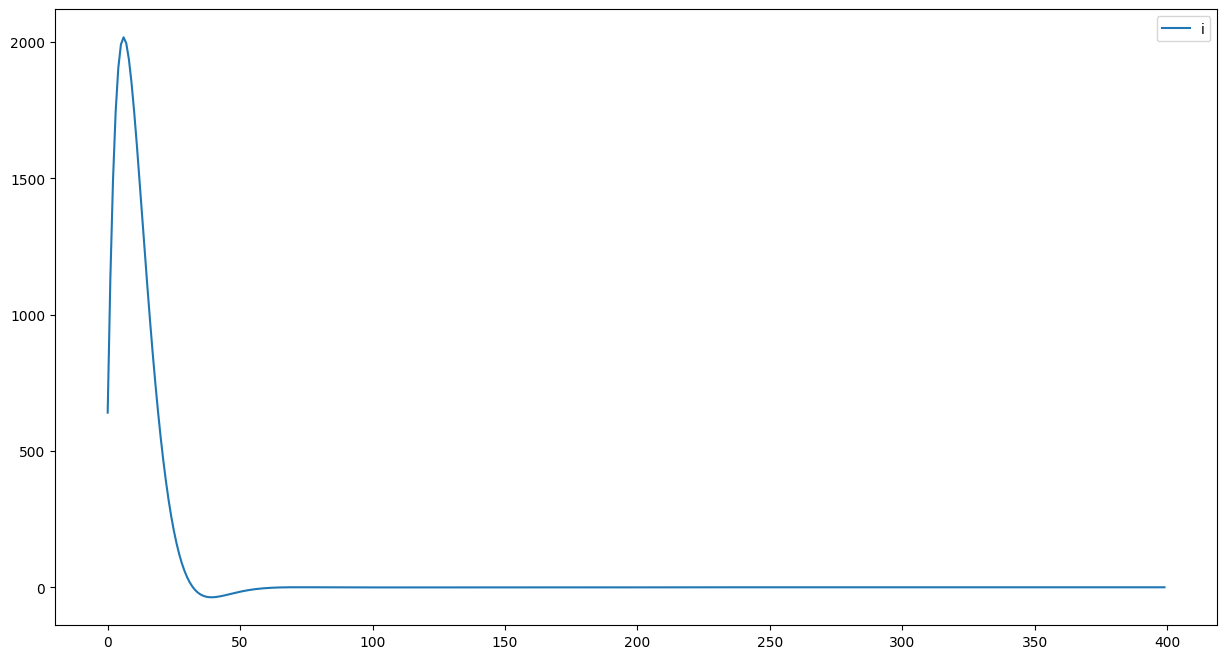

In [649]:
plt.plot(history_y_array[:, 0], label="i")
plt.legend()
plt.show()

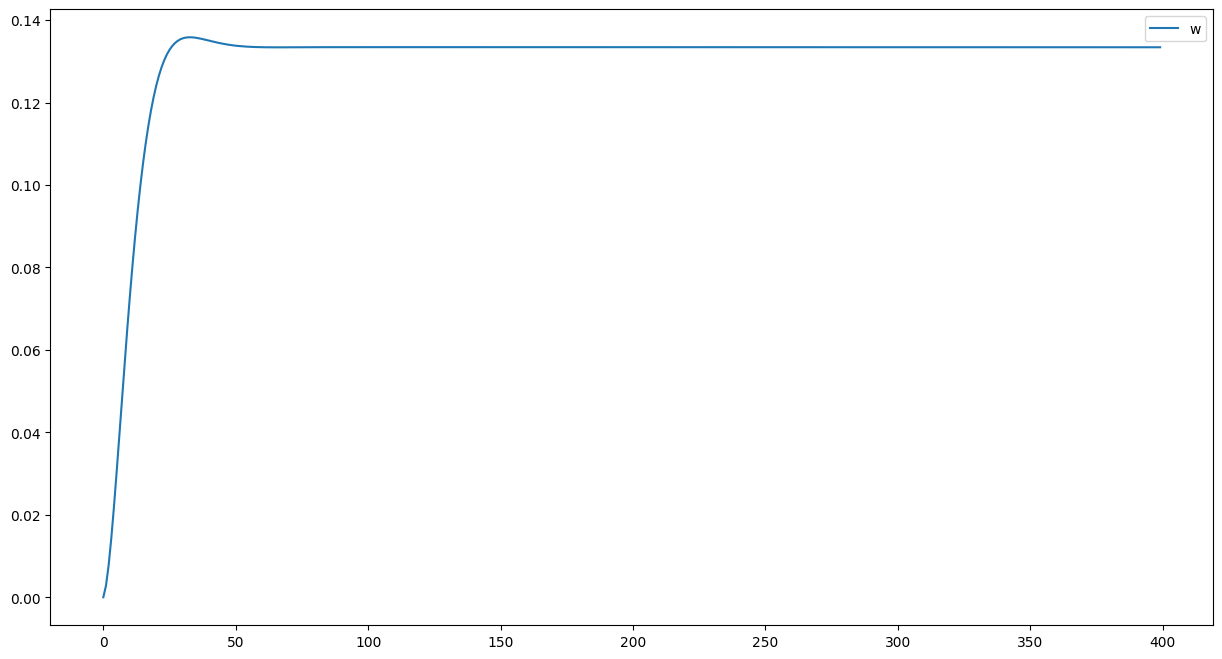

In [650]:
plt.plot(history_y_array[:, 1], label="w")
plt.legend()
plt.show()

<h3>РНС</h3>

Параметры

In [651]:
LW11 = (J*R*Te)/(2*(T*T*cF*cF + J*R*T + J*R*Te)) - T/(2*Te) + 1/2;
LW12 =  - (T*cF)/(2*R*Te) - (J*T*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
LW21 = (T*cF)/(2*J) + (R*T*Te*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
LW22 = (J*R*(T + Te))/(2*(T*T*cF*cF + J*R*T + J*R*Te)) + 1/2;

IW11 = (T*((J*R*Te)/(T*T*cF*cF + J*R*T + J*R*Te) + 1))/(2*R*Te);
IW12 =  (T*T*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
IW21 =  (T*T*cF)/(2*(T*T*cF*cF + J*R*T + J*R*Te));
IW22 = -(T*((J*R*(T + Te))/(T*T*cF*cF + J*R*T + J*R*Te) + 1))/(2*J);

Вычисление параметров ДПТ по весовым коэффициентам сети

In [652]:
J_m = -LW22/IW22*T
cF_m = -2*(1-LW22*IW21/LW12/IW22)*LW21*LW22/IW22
Te_m = T/2/(IW11*LW21*LW22/LW12/IW22 - LW11)
R_m = 2*LW21*LW22*(IW11*LW21*LW22/LW12/IW22 - LW11)/LW12/IW22

In [653]:
J_m, cF_m, Te_m, R_m

(172000.0, 74.94079999999998, 0.04236827810972299, 0.003681999999999998)

Матрица весовых коэфициентов

In [654]:
def sum(*args):
    return np.sum(args)
    

In [655]:
def linear_activation(x):
    return x

In [656]:
class UnitDelay:
    def __init__(self, init_value=0):
        self.value = init_value
        self.output_value = init_value
        
    def update(self, input_value):
        self.output_value = self.value
        self.value = input_value
        return self.output_value

    def get(self):
        return self.output_value

In [657]:
delay_w = UnitDelay()
delay_i = UnitDelay()
delay_w_0 = UnitDelay()
delay_i_0 = UnitDelay()

In [658]:
history_w = []
history_i = []

for i, t in enumerate(np.arange(0, sec, T)):
    w = linear_activation(sum(np.dot(IW22, 0), np.dot(IW21, 10), np.dot(LW22, delay_w.get()), np.dot(LW21, delay_i.get())))
    i = linear_activation(sum(np.dot(IW12, 0), np.dot(IW11, 10), np.dot(LW12, delay_w.get()), np.dot(LW11, delay_i.get())))

    delay_w.update(w)
    delay_i.update(i)
    
    history_w.append(delay_w_0.update(w))
    history_i.append(delay_i_0.update(i))

history_w_array = np.array(history_w)
history_i_array = np.array(history_i)

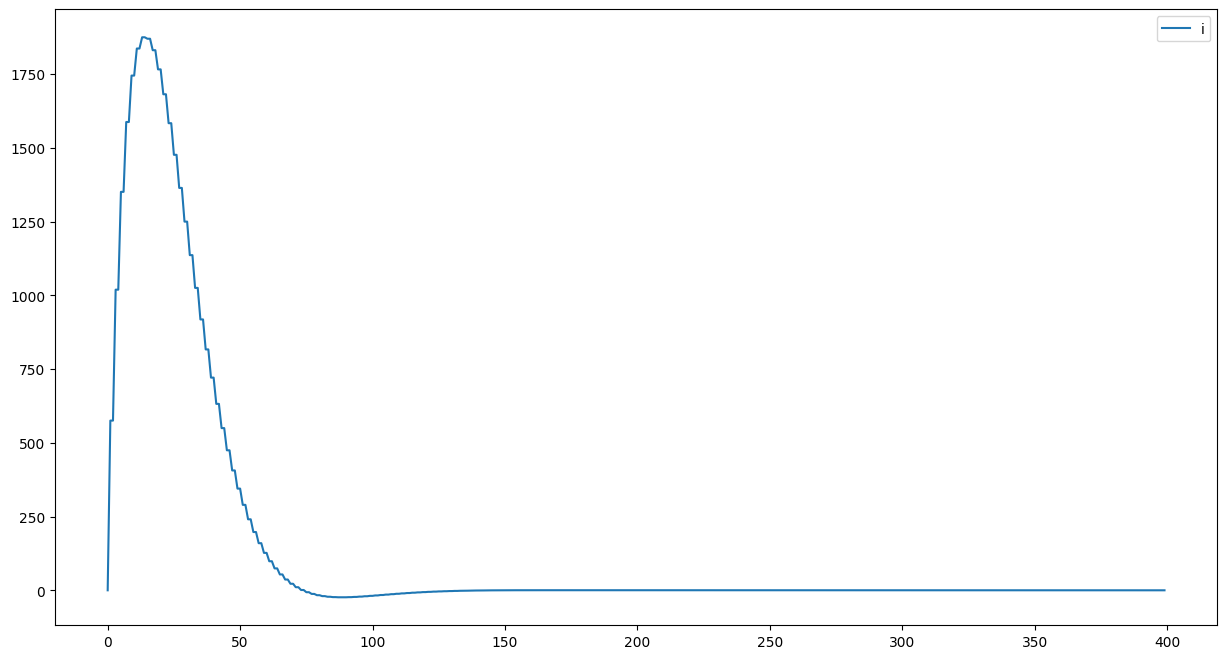

In [659]:
plt.plot(history_i_array, label="i")
plt.legend()
plt.show()

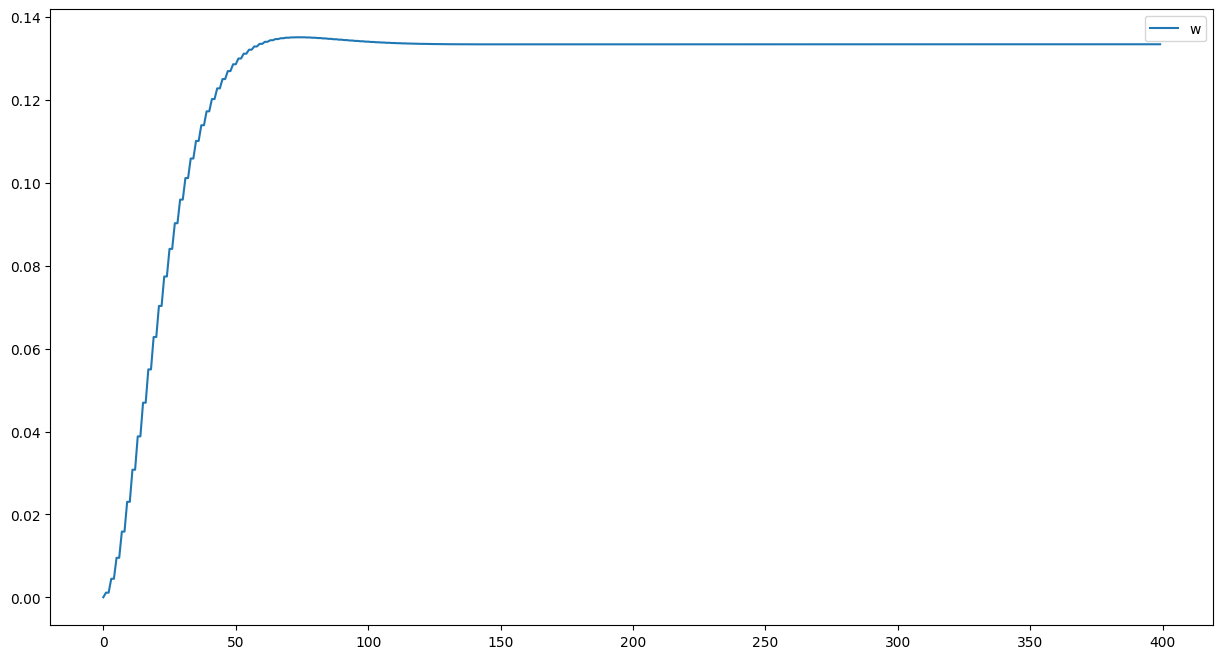

In [660]:
plt.plot(history_w_array, label="w")
plt.legend()
plt.show()

In [661]:
W = np.array([[LW11, LW12, IW11, IW12],
              [LW21, LW22, IW21, IW22]])

In [662]:
delay_w_1 = UnitDelay()
delay_i_1 = UnitDelay()

In [663]:
history_w_1 = []
history_i_1 = []


for i, t in enumerate(np.arange(0, sec, T)):
    y = np.dot(W, np.vstack((np.array([delay_i_1.get(), delay_w_1.get()]).reshape(2, 1), u[i])))
    history_i_1.append(delay_i_1.update(y[0]))
    history_w_1.append(delay_w_1.update(y[1]))
    
history_w_1_array = np.array(history_w_1)
history_i_1_array = np.array(history_i_1)


<ipython-input-663-8179be4879ea>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  history_w_1_array = np.array(history_w_1)
<ipython-input-663-8179be4879ea>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  history_i_1_array = np.array(history_i_1)


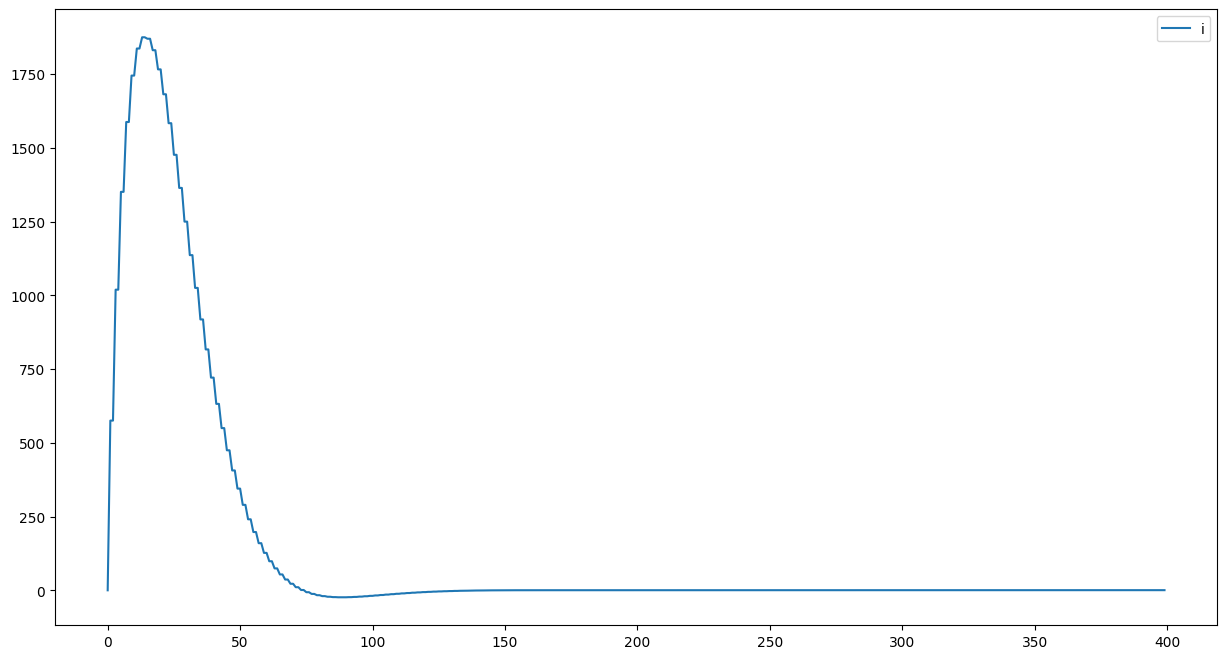

In [664]:
plt.plot(history_i_1_array, label="i")
plt.legend()
plt.show()

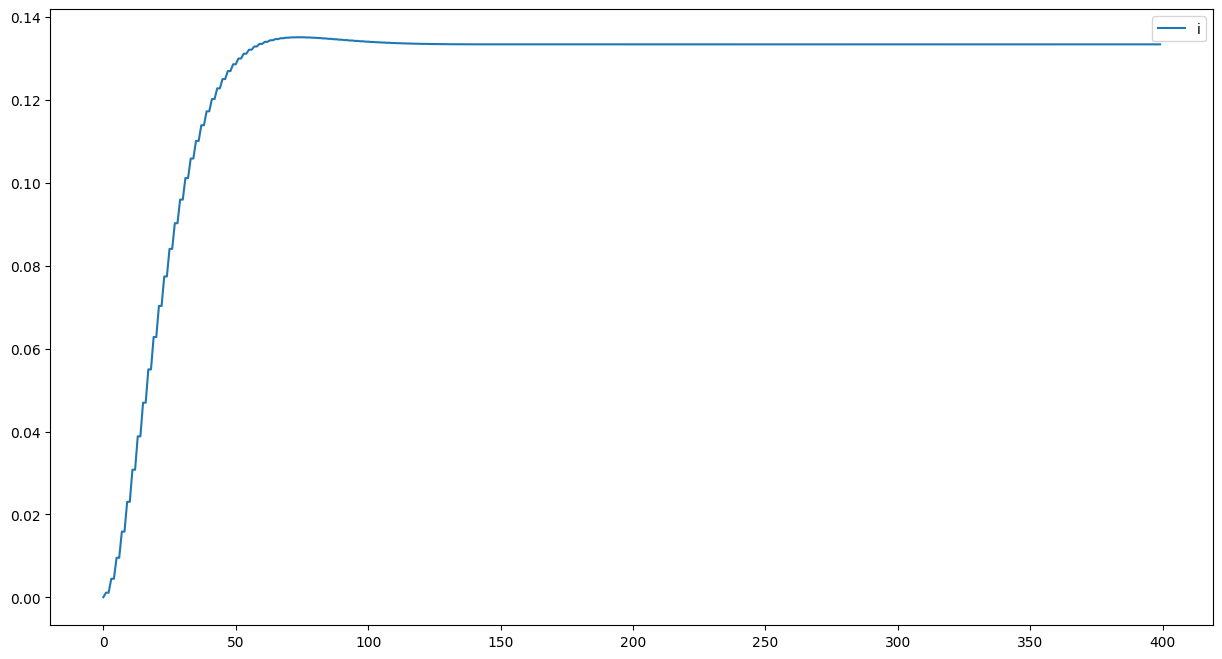

In [665]:
plt.plot(history_w_1_array, label="i")
plt.legend()
plt.show()

# W and I plot

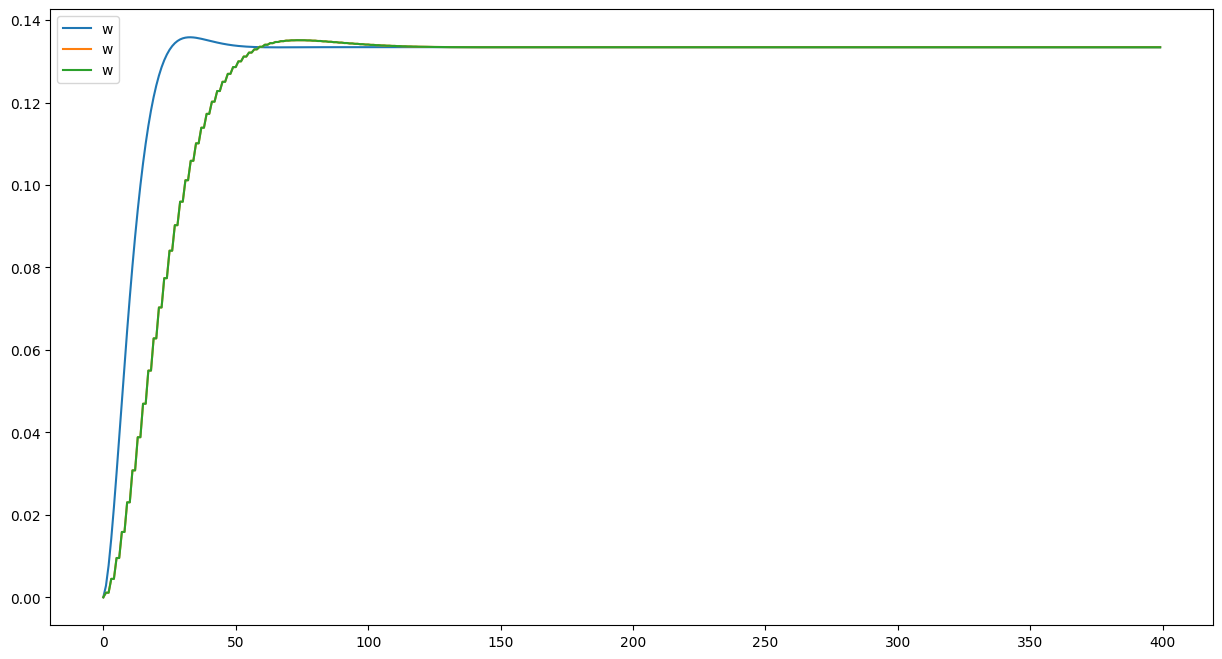

In [666]:
plt.plot(history_y_array[:, 1], label="w")
plt.plot(history_w_array, label="w")
plt.plot(history_w_1_array, label="w")
plt.legend()
plt.show()

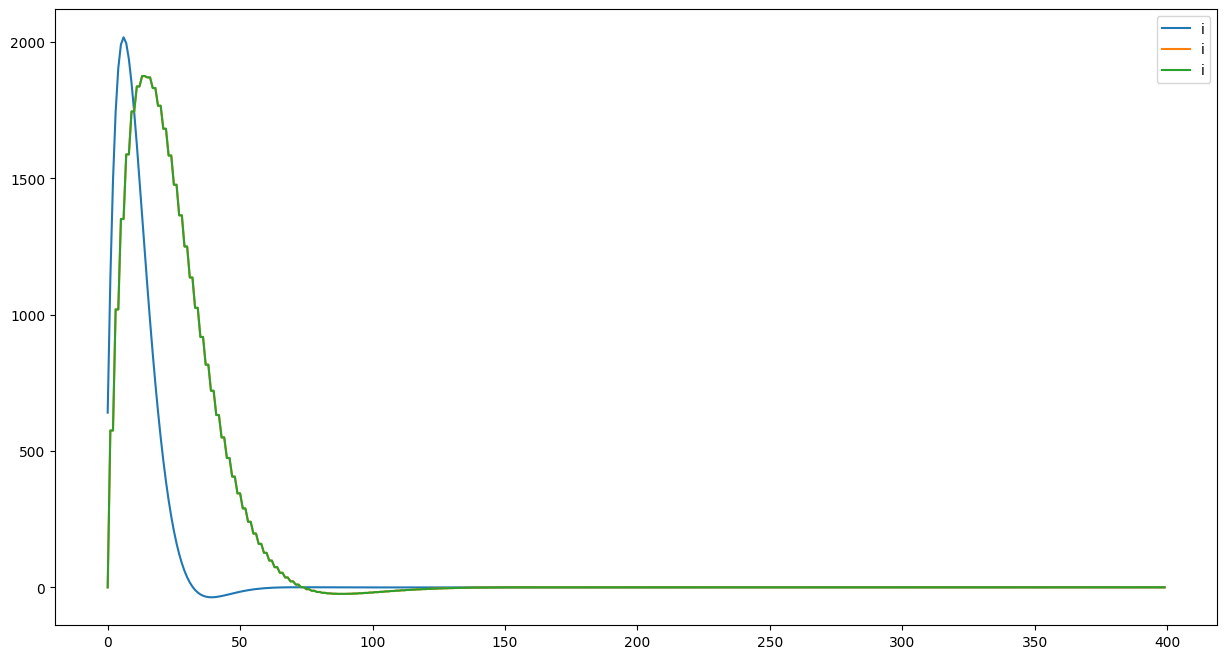

In [667]:
plt.plot(history_y_array[:, 0], label="i")
plt.plot(history_i_array, label="i")
plt.plot(history_i_1_array, label="i")
plt.legend()
plt.show()